In [2]:
import os
import sys
import lightgbm as lgb
import polars as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Setup paths
NOTEBOOK_DIR = os.getcwd()  # data_analysis
PROJ_DIR = os.path.dirname(NOTEBOOK_DIR)  # main project folder
MODEL_DIR = os.path.join(PROJ_DIR, "training", "trained_models")
DATA_DIR = os.path.join(PROJ_DIR, "jane-street-real-time-market-data-forecasting")

# Add training source to path for imports
sys.path.append(os.path.join(PROJ_DIR, "training"))
sys.path.append(os.path.join(PROJ_DIR, "training", "src"))
sys.path.append(os.path.join(PROJ_DIR, "training", "src", "utils"))

# Import our utility functions
from src.data_loading import DataLoader
from src.utils.metrics import r2_score_weighted

In [3]:
# Initialize data loader and get columns
data_loader = DataLoader(DATA_DIR)
feature_cols, exclude_cols = data_loader.get_feature_columns(
    pl.scan_parquet(os.path.join(DATA_DIR, "train.parquet"))
)

# Load and preprocess full dataset
print("Loading full dataset...")
train_df = pl.scan_parquet(os.path.join(DATA_DIR, "train.parquet")).collect().to_pandas()
train_df = data_loader.handle_nulls(train_df, feature_cols)

print(f"\nDataset shape: {train_df.shape}")
print(f"Date range: {train_df['date_id'].min()} to {train_df['date_id'].max()}")


📊 Analyzing column structure...
Found 79 features and 12 columns to exclude
Loading full dataset...

🔍 Processing null values...


Creating null flags:   3%|▎         | 2/79 [00:00<00:15,  4.91it/s]

  feature_00: 3,182,052 nulls (6.75%)
  feature_01: 3,182,052 nulls (6.75%)


Creating null flags:   5%|▌         | 4/79 [00:00<00:11,  6.75it/s]

  feature_02: 3,182,052 nulls (6.75%)
  feature_03: 3,182,052 nulls (6.75%)


Creating null flags:   8%|▊         | 6/79 [00:00<00:09,  7.72it/s]

  feature_04: 3,182,052 nulls (6.75%)


Creating null flags:  14%|█▍        | 11/79 [00:01<00:07,  9.35it/s]

  feature_08: 300,247 nulls (0.64%)


Creating null flags:  22%|██▏       | 17/79 [00:02<00:07,  8.67it/s]

  feature_15: 1,209,299 nulls (2.57%)
  feature_16: 261 nulls (0.00%)


Creating null flags:  24%|██▍       | 19/79 [00:02<00:07,  8.17it/s]

  feature_17: 201,838 nulls (0.43%)
  feature_18: 226 nulls (0.00%)


Creating null flags:  27%|██▋       | 21/79 [00:02<00:07,  8.18it/s]

  feature_19: 226 nulls (0.00%)


Creating null flags:  29%|██▉       | 23/79 [00:02<00:06,  8.42it/s]

  feature_21: 8,435,985 nulls (17.90%)


Creating null flags:  35%|███▌      | 28/79 [00:03<00:06,  8.15it/s]

  feature_26: 8,435,985 nulls (17.90%)
  feature_27: 8,435,985 nulls (17.90%)


Creating null flags:  42%|████▏     | 33/79 [00:04<00:05,  8.24it/s]

  feature_31: 8,435,985 nulls (17.90%)
  feature_32: 478,457 nulls (1.02%)


Creating null flags:  44%|████▍     | 35/79 [00:04<00:05,  7.98it/s]

  feature_33: 478,457 nulls (1.02%)


Creating null flags:  49%|████▉     | 39/79 [00:04<00:04,  8.01it/s]

  feature_37: 849 nulls (0.00%)


Creating null flags:  52%|█████▏    | 41/79 [00:05<00:04,  8.35it/s]

  feature_39: 4,300,649 nulls (9.13%)
  feature_40: 67,856 nulls (0.14%)


Creating null flags:  54%|█████▍    | 43/79 [00:05<00:04,  8.22it/s]

  feature_41: 1,093,012 nulls (2.32%)
  feature_42: 4,300,649 nulls (9.13%)


Creating null flags:  57%|█████▋    | 45/79 [00:05<00:04,  8.17it/s]

  feature_43: 67,856 nulls (0.14%)
  feature_44: 1,093,012 nulls (2.32%)


Creating null flags:  59%|█████▉    | 47/79 [00:05<00:04,  7.95it/s]

  feature_45: 317,163 nulls (0.67%)
  feature_46: 317,163 nulls (0.67%)


Creating null flags:  62%|██████▏   | 49/79 [00:06<00:03,  7.84it/s]

  feature_47: 87 nulls (0.00%)


Creating null flags:  66%|██████▌   | 52/79 [00:06<00:03,  8.24it/s]

  feature_50: 4,254,098 nulls (9.03%)
  feature_51: 13,805 nulls (0.03%)


Creating null flags:  68%|██████▊   | 54/79 [00:06<00:03,  8.22it/s]

  feature_52: 1,044,898 nulls (2.22%)
  feature_53: 4,254,098 nulls (9.03%)


Creating null flags:  71%|███████   | 56/79 [00:06<00:02,  8.16it/s]

  feature_54: 13,805 nulls (0.03%)
  feature_55: 1,044,898 nulls (2.22%)


Creating null flags:  73%|███████▎  | 58/79 [00:07<00:02,  8.46it/s]

  feature_56: 226 nulls (0.00%)
  feature_57: 226 nulls (0.00%)


Creating null flags:  76%|███████▌  | 60/79 [00:07<00:02,  8.09it/s]

  feature_58: 478,452 nulls (1.02%)


Creating null flags:  81%|████████  | 64/79 [00:07<00:01,  8.13it/s]

  feature_62: 292,827 nulls (0.62%)
  feature_63: 227,566 nulls (0.48%)


Creating null flags:  84%|████████▎ | 66/79 [00:08<00:01,  7.91it/s]

  feature_64: 237,663 nulls (0.50%)
  feature_65: 317,163 nulls (0.67%)


Creating null flags:  86%|████████▌ | 68/79 [00:08<00:01,  7.87it/s]

  feature_66: 317,163 nulls (0.67%)


Creating null flags:  95%|█████████▍| 75/79 [00:09<00:00,  7.84it/s]

  feature_73: 483,759 nulls (1.03%)
  feature_74: 483,759 nulls (1.03%)


Creating null flags:  97%|█████████▋| 77/79 [00:09<00:00,  8.05it/s]

  feature_75: 58,430 nulls (0.12%)
  feature_76: 58,430 nulls (0.12%)


Creating null flags: 100%|██████████| 79/79 [00:09<00:00,  8.07it/s]

  feature_77: 20,043 nulls (0.04%)
  feature_78: 20,043 nulls (0.04%)

📈 Forward filling values within symbol groups...


Forward fill completed in 123.10 seconds

⚠️ Backward filling remaining nulls (first rows)...
Backward fill completed in 121.26 seconds

Dataset shape: (47127338, 172)
Date range: 0 to 1698


In [14]:
# Model settings and setup
models = {
    #'Day240': "model_iter_970_valr2_0.012957280530144666.txt",
    #'Day50': "model_iter_472_valr2_0.007525290004666063.txt",
    #'Day500Val20': "model_iter_681_valr2_0.0076366825565921115.txt",
    '-750Val20': "model_iter_891_valr2_0.008637235153353351.txt"
    #'4':"model_iter_667_valr2_0.007462378707644102.txt"
}



def setup_prediction(model_name):
    """Load and setup model for prediction"""
    model_path = os.path.join(MODEL_DIR, model_name)
    return lgb.Booster(model_file=model_path)

# Load all models
loaded_models = {name: setup_prediction(filename) 
                for name, filename in models.items()}

In [15]:
# Define validation window sizes to test (in days)
val_windows = [5, 10, 12, 15, 17, 20] #, 30, 50, 100, 120, 180, 240]

# Store results
results = []

# Get feature columns for model
model_cols = [col for col in train_df.columns 
             if col not in exclude_cols and col != 'responder_6']

# Calculate scores for each window size and model
print("\nTesting different validation windows...")
for model_name, model in loaded_models.items():
    for window in tqdm(val_windows, desc=f"Testing {model_name}"):
        # Get the validation set
        val_start_date = train_df['date_id'].max() - window
        val_mask = train_df['date_id'] >= val_start_date
        
        # Split data
        X_val = train_df[model_cols].loc[val_mask].to_numpy()
        y_val = train_df['responder_6'].loc[val_mask].to_numpy()
        w_val = train_df['weight'].loc[val_mask].to_numpy()
        
        # Get predictions
        y_pred = model.predict(X_val)
        
        # Calculate score
        score = r2_score_weighted(y_val, y_pred, w_val)
        
        results.append({
            'model': model_name,
            'window_size': window,
            'score': score,
            'n_samples': len(y_val)
        })


Testing different validation windows...


Testing -750Val20: 100%|██████████| 6/6 [02:24<00:00, 24.05s/it]


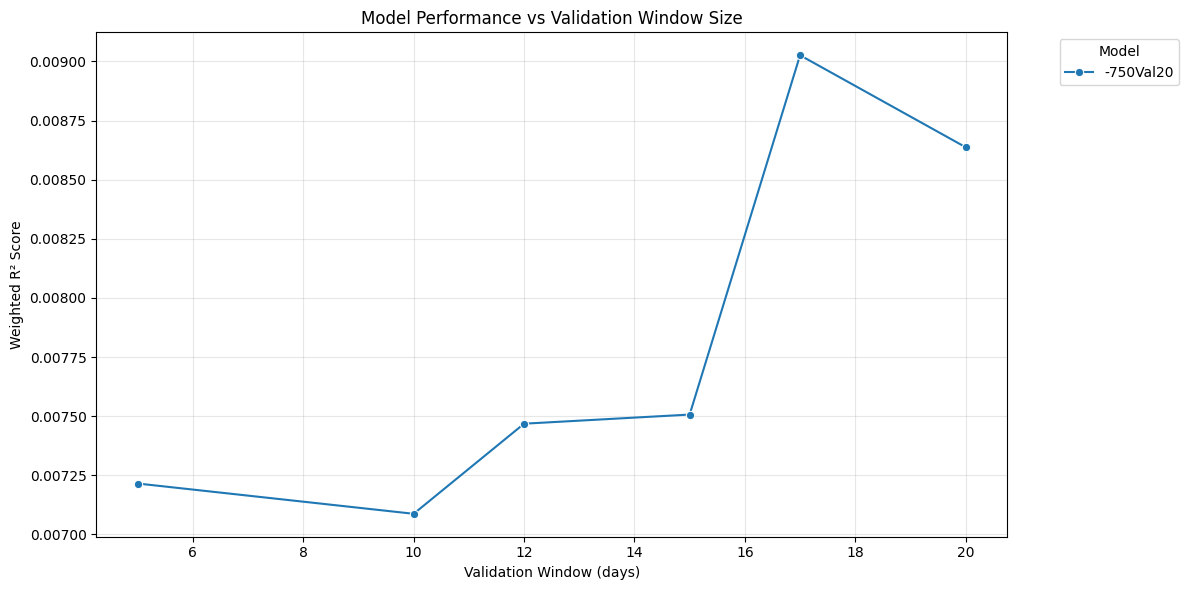


Detailed Results:
model        -750Val20
window_size           
5             0.007215
10            0.007087
12            0.007468
15            0.007507
17            0.009026
20            0.008637


In [17]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plot results
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='window_size', y='score', hue='model', marker='o')
plt.title('Model Performance vs Validation Window Size')
plt.xlabel('Validation Window (days)')
plt.ylabel('Weighted R² Score')
plt.grid(True, alpha=0.3)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print detailed results
print("\nDetailed Results:")
pivot_df = results_df.pivot(index='window_size', columns='model', values='score')
print(pivot_df.round(6).to_string())

In [18]:
import pandas as pd
import numpy as np

# Create dataframe from the results
window_sizes = [5, 10, 12, 15, 17, 20]
results = {
    'window_size': window_sizes,
    'Day120': [0.005530, 0.005648, 0.005478, 0.005652, 0.007101, 0.006685],
    'Day240': [0.005827, 0.006291, 0.006288, 0.006119, 0.007201, 0.006599],
    'Day50': [0.005682, 0.006246, 0.006285, 0.006237, 0.007608, 0.007182],
    'Day500Val20': [0.006283, 0.006215, 0.006387, 0.006474, 0.008001, 0.007637],
    'model4': [0.005718, 0.006379, 0.006341, 0.006271, 0.007712, 0.007212],
    '-750Val20': [0.007215, 0.007087, 0.007468, 0.007507, 0.009026, 0.008637]
}

# LB scores for each model
lb_scores = {
    'Day240': 0.0039,
    'Day50': 0.0043,
    'Day500Val20': 0.0047,
    'model4': 0.0042,
    '-750Val20': 0.0045
}

# Calculate correlation for each window size
window_correlations = {}
for window_idx, window_size in enumerate(window_sizes):
    # Get all validation scores for this window size
    validation_scores = []
    lb_scores_list = []
    
    for model, lb_score in lb_scores.items():
        model_name = 'Day500Val20' if model == 'Day500Val20' else model
        validation_scores.append(results[model_name][window_idx])
        lb_scores_list.append(lb_score)
    
    correlation = np.corrcoef(validation_scores, lb_scores_list)[0,1]
    window_correlations[window_size] = correlation

# Print correlations sorted by value
sorted_correlations = sorted(window_correlations.items(), key=lambda x: abs(x[1]), reverse=True)
print("\nWindow Size Correlations with LB scores (sorted by absolute correlation):")
for window_size, correlation in sorted_correlations:
    print(f"Window size {window_size}: {correlation:.4f}")


Window Size Correlations with LB scores (sorted by absolute correlation):
Window size 20: 0.7354
Window size 17: 0.6757
Window size 5: 0.5615
Window size 15: 0.5307
Window size 12: 0.3917
Window size 10: 0.2366
